# Isotropic elastic wave propagator

This tutorial was prepared by Eduardo Moscatelli emoscatelli@usp.br

This tutorial is an introduction to the isotropic elastic wave propagator of spyro. The tutorial is an adaption of the acoustic simple forward notebook, so the reader may be interested in consulting that notebook before reading this tutorial for more details on the passages that are not addressed in detail here. The objective is to show that several features of spyro are common between the propagators.

First, the notebook environment is configured and the required modules are impored.

In [1]:
# For use in colab only:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

!pip install git+https://github.com/NDF-Poli-USP/spyro.git@issue_0142-fixing-failing-pip-install

%matplotlib inline
import spyro
import numpy as np

Then, the commands that are the same as in the acoustic example are run (only the final time is increased to 1.5 for a better visualization of the shot records).

In [2]:
dictionary = {
    "options": {
        "cell_type": "Q",
        "variant": "lumped",
        "degree": 4,
        "dimension": 2,
    },
    "parallelism": {
        "type": "automatic",
    },
    "mesh": {
        "Lz": 3.0,
        "Lx": 3.0,
        "mesh_file": None,
        "mesh_type": "firedrake_mesh",
    },
    "acquisition": {
        "source_type": "ricker",
        "source_locations": [(-1.1, 1.5)],
        "frequency": 5.0,
        "delay": 0.2,
        "delay_type": "time",
        "receiver_locations": spyro.create_transect((-1.9, 1.2), (-1.9, 1.8), 300),
    },
    "time_axis": {
        "initial_time": 0.0,
        "final_time": 1.5,
        "dt": 0.001,
        "output_frequency": 100,
        "gradient_sampling_frequency": 1,
    },
    "visualization": {
        "forward_output": True,
        "forward_output_filename": "results/forward_output.pvd",
        "fwi_velocity_model_output": False,
        "velocity_model_filename": None,
        "gradient_output": False,
        "gradient_filename": "results/Gradient.pvd",
        "adjoint_output": False,
        "adjoint_filename": None,
        "debug_output": False,
    },
}

The isotropic elastic wave propagator requires three parameters: the density ($\rho$) and two parameters for the constitutive behavior. There are multiple pairs of constitutive parameters that can describe an isotropic linear elastic solid behavior. In spyro, the user may choose between providing the P-wave and S-wave velocities ($c_p$ and $c_s$), or the Lamé parameters ($\lambda$ and $\mu$). The relation between these two pairs of parameters is:
$$c_p = \sqrt{\frac{\lambda+2\mu}{\rho}} \qquad\text{and}\qquad c_s = \sqrt{\frac{\mu}{\rho}}$$
This tutorial follows the first option to keep it close to the acoustic example, which sets the P-wave velocity. So, the synthetic data dictionary is set as follows.

In [3]:
dictionary["synthetic_data"] = {
    "type": "object",
    "density": 0.1,
    "p_wave_velocity": 1.5,
    "s_wave_velocity": 1.0,
    "real_velocity_file": None,
}

The isotropic elastic solver of spyro implements a pure displacement formulation of the elastic problem. Therefore, the displacement vector is the output and the loads are vectors with one component per direction. The body forces of the elastic wave are set as follows.

In [4]:
dictionary["acquisition"]["amplitude"] = np.array([0, 1])

The class that implements the isotropic elastic wave propagator is the `IsotropicWave`. First, we create an instance of this class (the warning messages may be ignored).

In [5]:
wave = spyro.IsotropicWave(dictionary)

Parallelism type: automatic


/home/firedrake/shared/spyro/spyro/io/model_parameters.py:572: UserWarning: No velocity model set initially. If using user defined conditional or expression, please input it in the Wave object.
  warnings.warn(
/home/firedrake/shared/spyro/spyro/solvers/wave.py:84: UserWarning: No mesh file, Firedrake mesh will be automatically generated.
  warnings.warn(


We set the mesh parameters to define a periodic mesh for this example.

In [6]:
wave.set_mesh(mesh_parameters={"dx": 0.02, "periodic": True})

Then, the wave propagation may start.

In [7]:
wave.forward_solve()

Saving output in: results/forward_outputsn0.pvd


/home/firedrake/firedrake/src/ufl/ufl/utils/sorting.py:89: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
/home/firedrake/firedrake/src/ufl/ufl/utils/sorting.py:89: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "


Simulation time is:        0.0 seconds
Simulation time is:        0.1 seconds
Simulation time is:        0.2 seconds
Simulation time is:        0.3 seconds
Simulation time is:        0.4 seconds
Simulation time is:        0.5 seconds
Simulation time is:        0.6 seconds
Simulation time is:        0.7 seconds
Simulation time is:        0.8 seconds
Simulation time is:        0.9 seconds
Simulation time is:        1.0 seconds
Simulation time is:        1.1 seconds
Simulation time is:        1.2 seconds
Simulation time is:        1.3 seconds
Simulation time is:        1.4 seconds
Simulation time is:        1.5 seconds


The final displacement field may be visualized with the following function.

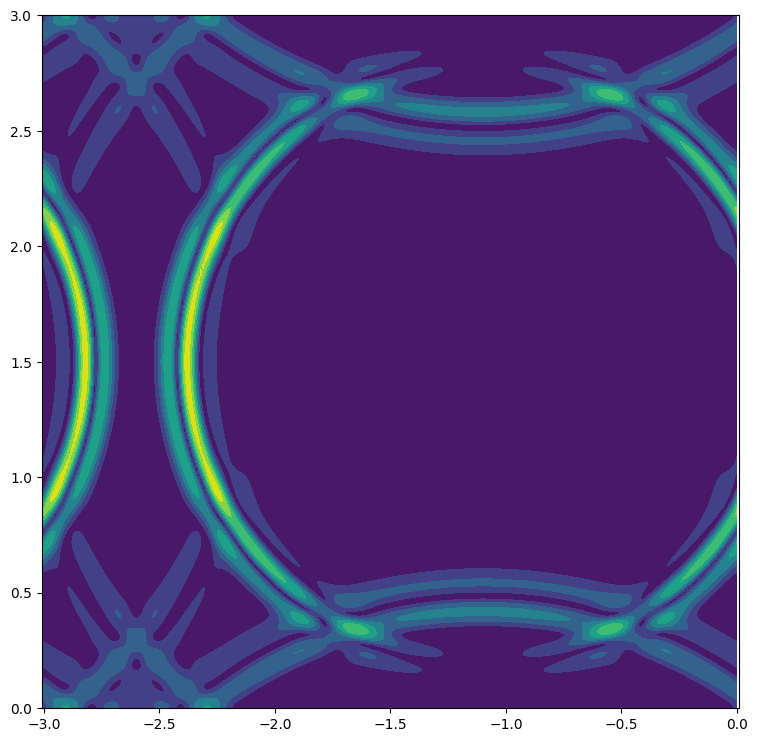

In [8]:
spyro.plots.plot_function(wave.u_n)

The elastic wave equation has one shot record for each direction. Therefore, the user must inform the plotting function the desired direction through the `out_index` parameter. The shot record in the $z$ direction is obtained by setting `out_index=0` as seen in the example below.

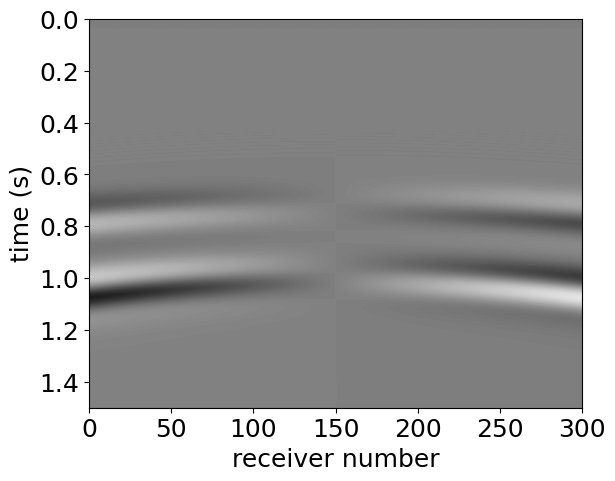

In [9]:
last_displacement = wave.u_n.dat.data[:]
u_max = np.max(last_displacement[:, 0])
spyro.plots.plot_shots(wave, contour_lines=100, vmin=-u_max, vmax=u_max, show=True, out_index=0)

Then, the shot record in the $x$ direction is obtained by setting `out_index=1`. It is seen that the shot records are in accordance with the alignement of the receivers.

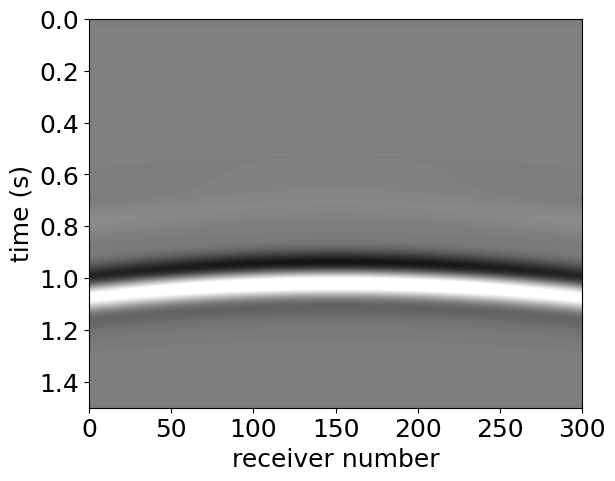

In [10]:
u_max = np.max(last_displacement[:, 1])
spyro.plots.plot_shots(wave, contour_lines=100, vmin=-u_max, vmax=u_max, show=True, out_index=1)